# Model Interpretability and Independent validation using model with transfer learning over independent validation dataset

In this notebook we are exploring the results of the clinical transformer to identify the important features (functional groups, feature permutation importance) as well as the impact on survival (Kapplan-Meier curves on the predicted populations). 

In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append('../../../codeocean/environment/clinical_transformer/')

In [2]:
from xai.models.explainer import TransformerSurvivalEvaluator
from xai.models.explainer import survival_attention_scores
from xai.models import load_transformer

2025-08-14 17:44:58.167336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 17:44:58.225427: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 17:44:58.579785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenwanxiang/anaconda3/lib:
2025-08-14 17:44:58.579829: W tensorflow/compiler/xla/stream_exe

In [3]:
import pandas as pd
from samecode.random import set_seed
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from samecode.survival.plot import KMPlot
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index as lfcindex
import seaborn as sns
from shap.plots import colors
from glob import glob
import os
colors = [colors.blue_rgb, colors.red_rgb]

In [4]:
n_feats = 43

2025-08-14 17:45:02.207579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-14 17:45:02.207597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: wu
2025-08-14 17:45:02.207600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: wu
2025-08-14 17:45:02.207655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-08-14 17:45:02.207668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.230.2
2025-08-14 17:45:02.207848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-crit

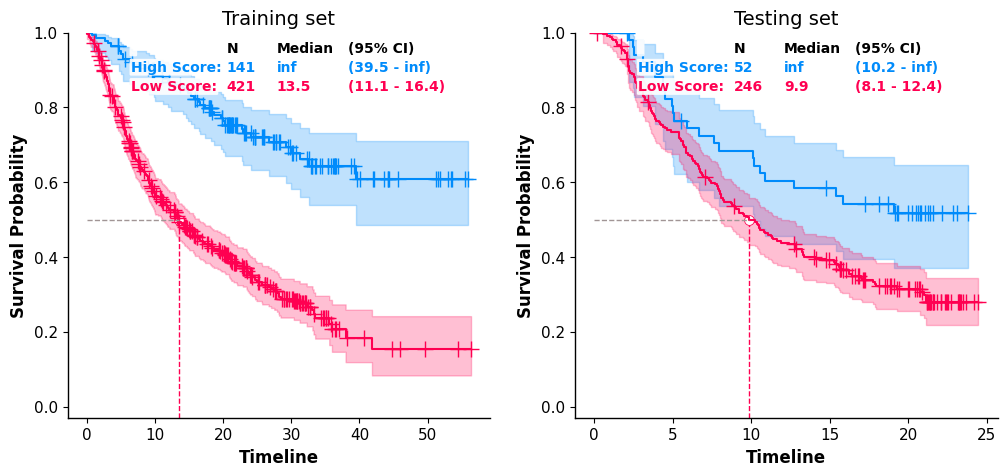

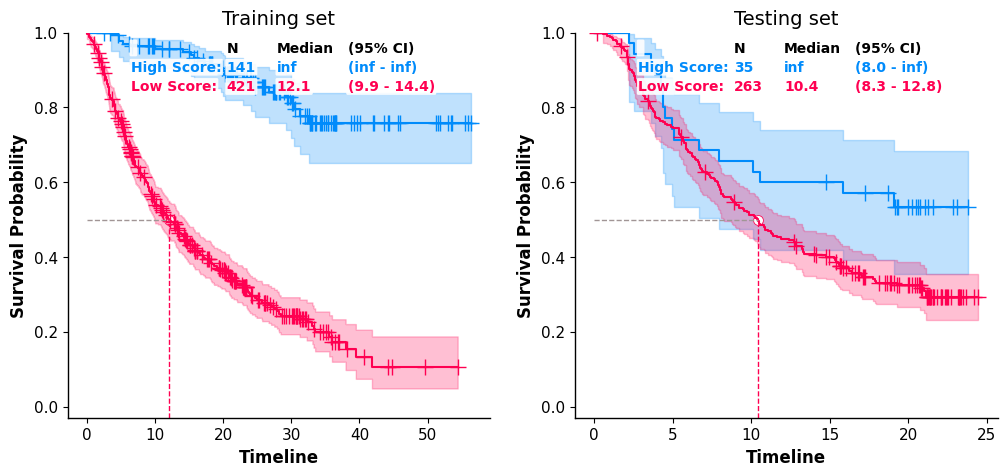

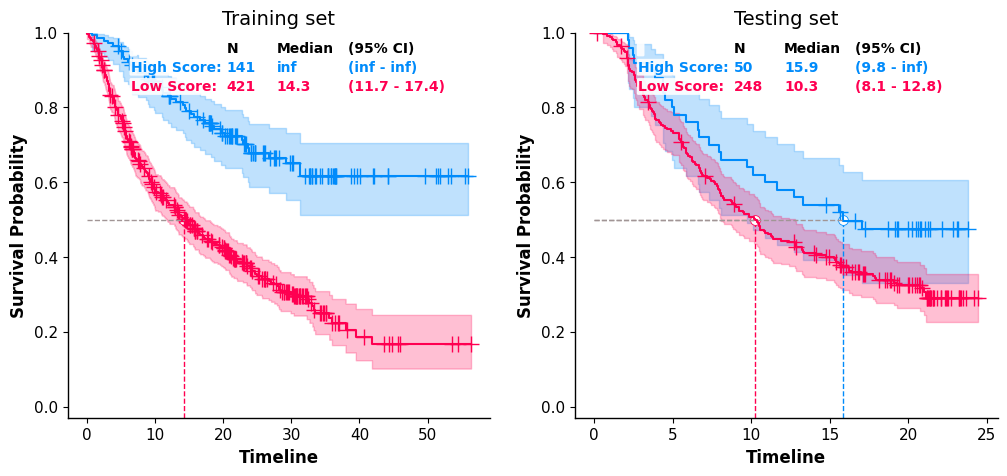

In [5]:
p0 = './results/TransferLearningSurvival_all/model.E002000.h5/'
p1 = './results/TransferLearningSurvival/model.E002000.h5/'
p2 = './results/Survival/'

cindex_res = []
for path in [p0, p1, p2]:
    
    train_data = pd.read_csv('./data/dataset-train.data.csv')
    train_data['sample_id'] = train_data.index
    test_data = pd.read_csv('./data/dataset-test.data.csv')

    test_data['sample_id'] = test_data.index
    features = train_data.columns[-n_feats:].tolist()

    sample_id = 'sample_id'
    all_epoch = 300
    if path == p0:
        all_epoch = 88
    res = pd.Series(glob(os.path.join(path, '*/history.csv')))

    pp = res.apply(lambda x:x.replace(path, ''))
    fd = pp.apply(lambda x:x.split('/')[0])
    eps = res.apply(lambda x:pd.read_csv(x).val_loss.idxmin())
    dfres = pd.concat([res,fd,eps], axis=1)
    best_model_paths =dfres.set_index(1)[2]

    
    train_beta  = []
    test_beta = []
    train_c = []
    test_c = []

    for run, best_epoch in best_model_paths.items():
        
        epoch = best_epoch
        trainer = load_transformer(path, run, epoch=epoch)
        transformed_data = trainer.data_converter.transform(train_data).reset_index(drop=True)

        set_seed(0)

        evaluator = TransformerSurvivalEvaluator(model=trainer)

        train_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
            transformed_data, evaluator, iterations=1, sample_id=sample_id
        )

        train_cindex = lfcindex(train_data['time'], train_data['β'], train_data['event'])

        transformed_test_data = trainer.data_converter.transform(test_data).reset_index(drop=True)


        evaluator = TransformerSurvivalEvaluator(model=trainer)

        test_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
            transformed_test_data, evaluator, iterations=10, sample_id=sample_id
        )

        test_cindex = lfcindex(test_data['time'], test_data['β'], test_data['event'])

        test_c.append(test_cindex)
        train_c.append(train_cindex)
        test_beta.append(test_data['β'])     
        train_beta.append(train_data['β'])

    df_cindex = pd.DataFrame([test_c, train_c]).T
    df_cindex.columns = ['test_cindex', 'train_cindex']
    
    cindex_dict = df_cindex.mean().to_dict()
    cindex_res.append(cindex_dict)
    
    train_βs = pd.concat(train_beta, axis=1)
    test_βs = pd.concat(test_beta, axis=1)


    test_βs.columns = ['β_%s' % i for i in range(len(test_βs.columns))]
    train_βs.columns = ['β_%s' % i for i in range(len(train_βs.columns))]


    test_data['β'] = test_βs.mean(axis=1)
    train_data['β'] = train_βs.mean(axis=1)
    
    median_cutoff = np.quantile(train_data.β, 0.75)


    test_data['population'] = (test_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])
    train_data['population'] = (train_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5))
    KMPlot(train_data, time='time', event='event', label=['population']).plot(ax=axs[0], 
                                                                              colors = colors, 
                                                                              title='Training set',
                                                                              ci_show=True,ci_alpha=0.10,

                                                                             )
    KMPlot(test_data, time='time', event='event', label=['population']).plot(ax=axs[1],
                                                                             colors = colors, ci_show=True,
                                                                             ci_alpha=0.10,
                                                                             title='Testing set')
    
    test_data = test_data.join(test_βs)
    train_data = train_data.join(train_βs)
    
    test_data.to_csv(os.path.join(path, 'test_data.csv'))
    train_data.to_csv(os.path.join(path, 'train_data.csv'))
    fig.savefig(os.path.join(path, 'train_test_km.svg'), bbox_inches='tight')
    df_cindex.to_csv(os.path.join(path, 'train_test_cindex.csv'))

In [6]:
cindex_res

[{'test_cindex': 0.573589455512016, 'train_cindex': 0.6792051196297668},
 {'test_cindex': 0.5670786178171158, 'train_cindex': 0.7352417452297235},
 {'test_cindex': 0.5649275203463677, 'train_cindex': 0.648859743476178}]